In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import unitary_group

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.waveguide import Waveguide, add_absorbing_boundary
from tdwg_lib.helpers import smoothen1d, smoothen2d, timestring
from tdwg_lib.mode_solver import solve_modes
from tdwg_lib.pnn_utils import L2, has_converged
from tdwg_lib import pnn_utils 
import tdwg_lib.ftutils_torch as ftutils

## Helper functions

In [3]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, modes, device, res_x=1, res_z=1):
        super(TDwgNet, self).__init__()
        self.device = device
        
        # Initialize trainable modulation parameter with bounds [0.05, 0.95]
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95])
        
        self.delta_n_val = delta_n_val  # Maximum refractive index change
        self.scale_x = res_x  # Resolution limit in x-direction (smoothing scale)
        self.scale_z = res_z  # Resolution limit in z-direction (smoothing scale)
        
        self.input_modes = modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = modes.to(dtype=torch.complex64).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
    def forward(self, x, monitor=False):
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        delta_n_prog = self.delta_n_val*self.mod.clip(0., 1.)
        delta_n_prog = smoothen2d(self.wg.x_axis, self.wg.z_axis, delta_n_prog, scale_x=self.scale_x, scale_z=self.scale_z)

        # Project input coefficients onto input mode basis
        inputs = x.to(self.device) @ self.input_modes
        
        # Compute refractive index distribution: background + programmable index
        delta_n = self.wg.background_delta_n + delta_n_prog
        
        # Propagate through waveguide
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        # Project output fields onto output mode basis (overlap integral with dx scaling)
        a_out = output_beams @ self.output_modes.T * self.wg.dx
        return a_out

In [4]:
def run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size, device, gamma=0.99, print_interval=1, save_model=False):
    """Train optical network to implement target unitary transformation."""
    # Setup optimizer and scheduler
    optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    U_target = U_target.to(device)
    loss_list = []
    
    # Prepare batches
    n = len(tdwg_pnn.input_modes)  # Number of modes
    indices = np.arange(n)
    batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into batches

    tdwg_pnn.train()
    for i in range(iterations):
        optimizer.zero_grad()  # Reset gradients

        # Loop over batches
        for indices in batch_indices:
            # Forward pass: compute numerical unitary for this batch
            U_num = tdwg_pnn.forward(torch.eye(n, dtype=torch.complex64)[indices])
            
            # Objective loss: L2 distance between numerical and target unitary
            l_objective = L2(U_target[indices], U_num)
    
            # Lagrangian penalty: enforce parameter bounds (limiting largest refractive index change)
            l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp=1, factor=20)
            
            # Total loss
            l = l_objective + l_lagrange
            l.backward()  # Compute gradients
            
        optimizer.step()  # Update parameters
        scheduler.step()  # Decay learning rate
        loss_list.append(l.detach().cpu().data)

        # Print progress
        if i % print_interval == 0:
            print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
        
        # Early stopping if converged
        if has_converged(loss_list, std_threshold=0.001):
            print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            break
        
        # Save model checkpoint
        if save_model:
            torch.save({
                    'epoch': i,
                    'model_state_dict': tdwg_pnn.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': l,
                }, 'saved_model.pt')
            
    return loss_list

## Setting up waveguide

In [5]:
NMODES = 100  # Number of waveguide modes
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹

# Training parameters
SEED = 1  # Random seed for sampling target unitary matrix
ITERATIONS = 500  # Number of training epochs
LR = 0.025  # Learning rate for optimizer

# Waveguide design parameters
NEFF = 3.0  # Effective refractive index of slab mode
DN_WG = 0.1  # Step-index change for waveguide core
DELTA_N_VAL = 0.005  # Maximum programmable refractive index change
LZ = 7000.0  # Total propagation length in μm

# Calculate waveguide dimensions based on number of modes
NA = np.sqrt(2*NEFF*DN_WG)  # Numerical aperture (approximate)

D_WG = (1.5 * NMODES - 1) * LAMBDA0 / 2 / NA  # Waveguide width to support NMODES modes
LAMBDA_Z = LAMBDA0 / DN_WG  # Expected necessary resolution in z
LAMBDA_X = LAMBDA0 / 2 / NA  # Expected necessary resolution in x

# Transverse (x) axis with resolution determined by numerical aperture
LX = D_WG + 40  # Width of simulation area in μm
NX = LX / LAMBDA_X * 10  # 10 grid points per smallest resolution feature
NX = int(2**np.ceil(np.log2(NX)))  # Make NX a power of 2 for FFT efficiency
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis with resolution determined by index contrast
NZ = int(LZ / LAMBDA_Z * 5/2)*2  # 5 grid points per resolution feature (even integer for symmetry)
Z_AXIS = np.linspace(0, LZ, NZ)  # Propagation coordinate array
DZ = Z_AXIS[1] - Z_AXIS[0]  # Propagation step size in μm

In [6]:
# Print waveguide design parameters
print(f'N_modes = {NMODES}')
print(f'dn_wg = {DN_WG}')
print(f'dn_prog = {DELTA_N_VAL}')
print(f'Lx = {D_WG:.0f}')
print(f'Lz = {LZ:.0f}')

print(f'NA = {NA:.2f}')
print(f'Λx={LAMBDA_X:.2f}, Λz={LAMBDA_Z:.2f}, Nz={NZ}')
print(f'dx={DX:.2f}, dz={DZ:.2f}, Nx={NX}')

N_modes = 100
dn_wg = 0.1
dn_prog = 0.005
Lx = 149
Lz = 7000
NA = 0.77
Λx=1.00, Λz=15.50, Nz=2258
dx=0.09, dz=3.10, Nx=2048


In [7]:
# Define step-index multimode waveguide with smoothed edges and absorbing boundaries
background_delta_n = torch.zeros(NX, dtype=torch.complex64)
background_delta_n[torch.abs(X_AXIS) < D_WG/2] = DN_WG  # Step-index profile
background_delta_n = smoothen1d(X_AXIS, background_delta_n, 3*LAMBDA0)  # Smooth edges over ~3 wavelengths
background_delta_n = add_absorbing_boundary(X_AXIS, background_delta_n, K0)  # Add PML boundaries

# Waveguide container object stores simulation geometry and parameters
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, background_delta_n, device=DEVICE)

This step may take a long time depending on the number of modes and the grid size (hence the additional code to save and reload previoulsy calculated modes). For 100 modes, it should not take longer than a few seconds. For 1000 modes, it may take multiple hours.

In [8]:
# Solve for first N TE modes and their propagation constants (betas) using eigenmode solver
betas, modes = solve_modes(wg.x_axis.numpy(), NEFF, K0, background_delta_n.numpy(), NMODES, fresnel=True)

# Convert to PyTorch tensors
betas = torch.from_numpy(betas)
modes = torch.from_numpy(modes)

# Save modes for potential reuse
torch.save(betas, f'betas_N={NMODES}.pt')
torch.save(modes, f'modes_N={NMODES}.pt')

In [9]:
# Load previously saved modes
betas = torch.load(f'betas_N={NMODES}.pt', weights_only=True)
modes = torch.load(f'modes_N={NMODES}.pt', weights_only=True)

In [10]:
# Normalize modes (scipy's mode solver may fail to normalize properly for very high N)
norm_factors = modes.abs().square().sum(-1) * DX  # Compute L2 norm for each mode
modes /= torch.sqrt(norm_factors)[None, :].T  # Normalize each mode

(0.0, 0.06)

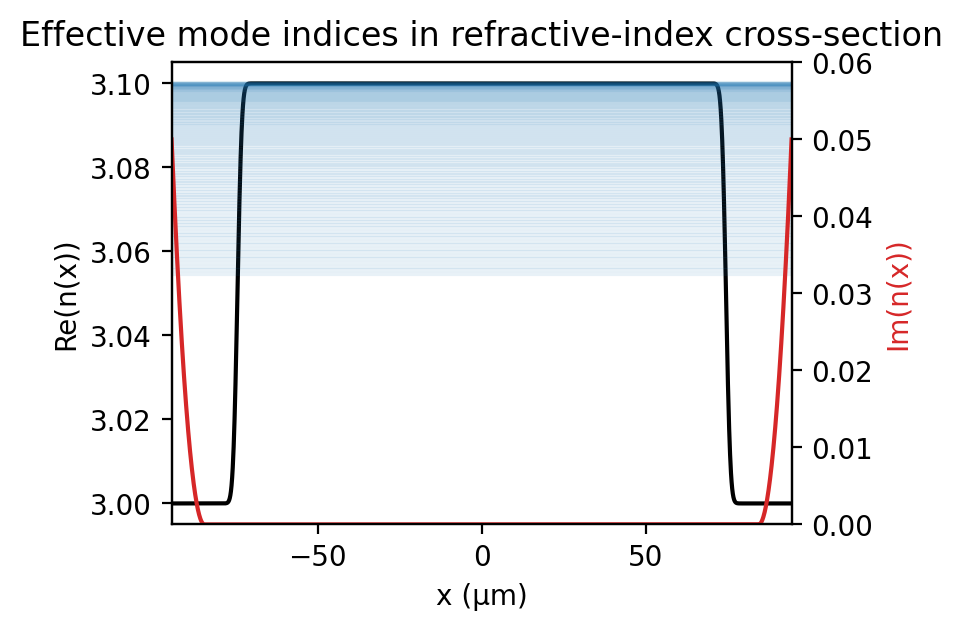

In [11]:
plt.figure(figsize=(4, 3), dpi=200)

plt.title('Effective mode indices in refractive-index cross-section')

# Plot real part of refractive index profile
plt.plot(X_AXIS, background_delta_n.real + NEFF, c='k')
plt.xlim(X_AXIS.min(), X_AXIS.max())
plt.ylabel('Re(n(x))')
plt.xlabel('x (μm)')

# Plot effective indices of all modes
for beta in betas:
    plt.axhline(beta/K0, c='tab:blue', alpha=0.1)

# Plot imaginary part (absorption) on secondary y-axis
plt.twinx()
plt.plot(X_AXIS, background_delta_n.imag, c='tab:red')
plt.ylabel('Im(n(x))', color='tab:red')
plt.ylim(0, 0.06)

Text(0.5, 1.0, 'First 8 waveguide modes')

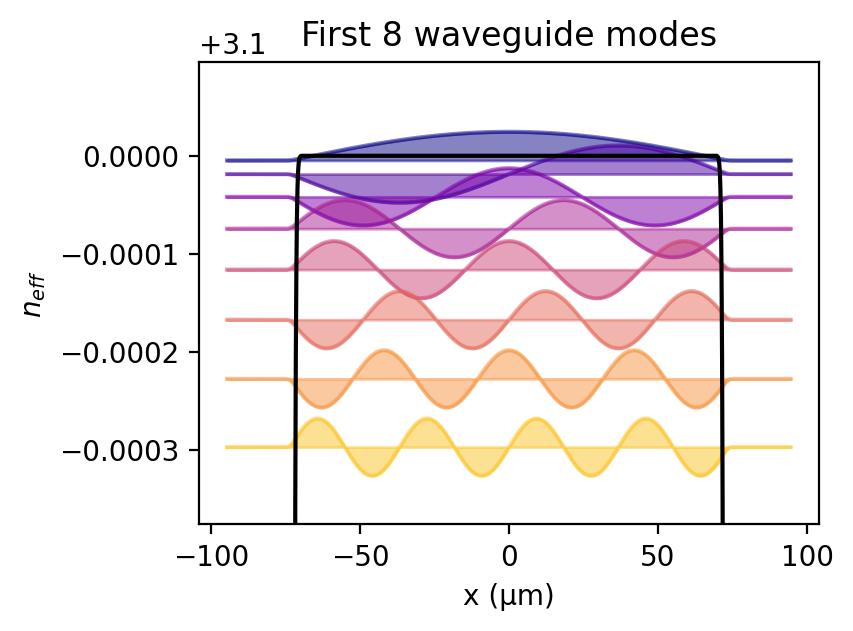

In [12]:
plt.figure(figsize=(4, 3), dpi=200)

# Plot first 8 waveguide modes with effective indices
for ind_mode, (mode, beta) in enumerate(zip(modes[:8], betas[:8])):
    # Plot mode profile offset by its effective index
    plt.fill_between(X_AXIS, beta/K0, mode/4e3 + beta/K0, label=f'$TE_{ind_mode}$', color=cm.plasma(ind_mode/8), alpha=0.5)
    plt.plot(X_AXIS, mode/4e3 + beta/K0, color=cm.plasma(ind_mode/8), alpha=0.5)

# Plot background index profile
plt.plot(X_AXIS, NEFF + background_delta_n.real, c='k')

plt.ylim(betas[8]/K0, betas[0]/K0 + 1e-4)
plt.xlabel('x (μm)')
plt.ylabel(r'$n_{eff}$')
plt.title('First 8 waveguide modes')

In [13]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

# Generate random target unitary matrix
U_target = unitary_group.rvs(NMODES, random_state=SEED)
U_target = torch.tensor(U_target, device=DEVICE)

# Create 2D-waveguide object with trainable index modulation
tdwg_pnn = TDwgNet(bpmsolver, wg, DELTA_N_VAL, modes, DEVICE)

## Train

This cell may take a few minutes. It took 2 minutes on a GPU (Nvidia A100) or around 50 minutes on a CPU (Intel Core Ultra 7 165 U).

If you encounter any memory problems, lower `batch_size`.

2025-10-04--16-02-11--Iteration: 0, Loss: 0.99995
2025-10-04--16-02-13--Iteration: 5, Loss: 0.60855
2025-10-04--16-02-15--Iteration: 10, Loss: 0.36872
2025-10-04--16-02-17--Iteration: 15, Loss: 0.24585
2025-10-04--16-02-19--Iteration: 20, Loss: 0.17350
2025-10-04--16-02-21--Iteration: 25, Loss: 0.12613
2025-10-04--16-02-23--Iteration: 30, Loss: 0.08148
2025-10-04--16-02-25--Iteration: 35, Loss: 0.04466
2025-10-04--16-02-27--Iteration: 40, Loss: 0.02897
2025-10-04--16-02-28--Iteration: 45, Loss: 0.01519
2025-10-04--16-02-30--Iteration: 50, Loss: 0.00920
2025-10-04--16-02-32--Iteration: 55, Loss: 0.00533
2025-10-04--16-02-34--Iteration: 60, Loss: 0.00389
2025-10-04--16-02-36--Iteration: 65, Loss: 0.00233
2025-10-04--16-02-38--Iteration: 70, Loss: 0.00179
2025-10-04--16-02-39--Iteration: 75, Loss: 0.00128
2025-10-04--16-02-41--Iteration: 80, Loss: 0.00094
2025-10-04--16-02-43--Iteration: 85, Loss: 0.00081
2025-10-04--16-02-45--Iteration: 90, Loss: 0.00069
2025-10-04--16-02-47--Iteration: 

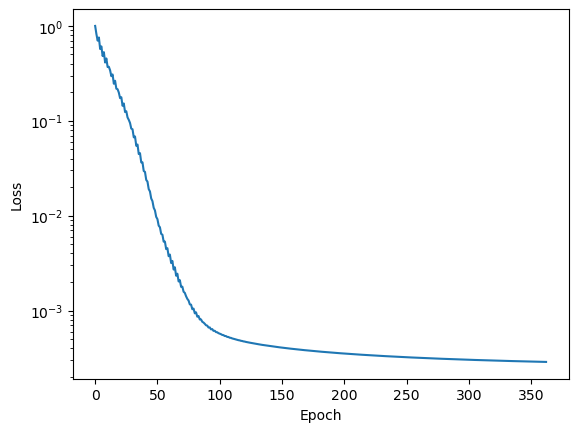

In [14]:
# Clear GPU cache before training
torch.cuda.empty_cache()

# Run training loop
loss_list = run_training_loop(tdwg_pnn, U_target, ITERATIONS, LR, batch_size=100, device=DEVICE, print_interval=5, gamma=0.995, save_model=False)

# Evaluate final unitary transformation
with torch.no_grad():
    U_num_inv = tdwg_pnn(torch.eye(NMODES, dtype=torch.complex64))

# Compute relative error
avg_error_inv = torch.mean(torch.abs(U_num_inv - U_target)) / torch.mean(torch.abs(U_target)) * 100
print(LR)
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

# Clear GPU cache after training
torch.cuda.empty_cache()

# Plot training loss history
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluate training

In [15]:
# Evaluate trained unitary transformation
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(NMODES, dtype=torch.complex64), monitor=False)

In [16]:
# Compute relative error: mean absolute difference normalized by target magnitude
avg_error_inv = torch.mean(torch.abs(U_num_inv - U_target)) / torch.mean(torch.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 0.82%


#### Plot inverse design results

In [17]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot refractive index: convert z to mm, take real part, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="coolwarm", vmax=vmax, vmin=0)
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()
    
    plt.show()

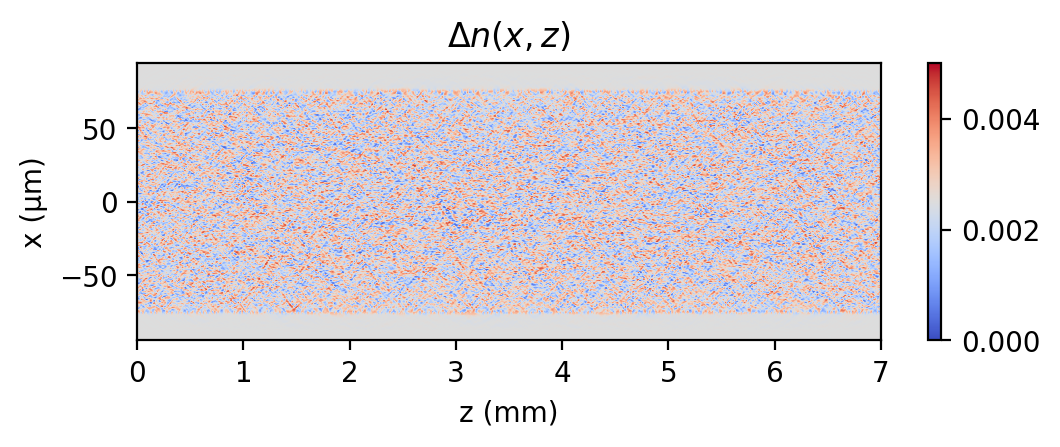

In [18]:
# Extract optimized refractive index: clip and scale trained modulation parameter
delta_n_inv = DELTA_N_VAL * (torch.clip(tdwg_pnn.mod.cpu().detach(), 0., 1.))

# Plot optimized refractive index distribution
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, DELTA_N_VAL)

In [19]:
def plot_unitary(U, vmax, title, colorbar_flag=True):
    """Plot magnitude of unitary matrix."""
    figsize_U = (2*1.3, 2*1.3)  # Figure size in inches
    
    # Plot main figure
    fig_main, ax = plt.subplots(figsize=figsize_U, dpi=200)
    img = plt.imshow(np.abs(U), cmap="bone_r", vmax=vmax)
    plt.title(title)
    
    if colorbar_flag:
        # Create a separate figure for the colorbar
        fig_cbar = plt.figure(figsize=(0.1, figsize_U[1]))
        cbar = plt.colorbar(img, cax=plt.gca())
    
    # Display figures
    plt.show()

In [20]:
# Set colorbar scale based on maximum magnitude in target unitary
VMAX = U_target.abs().max()

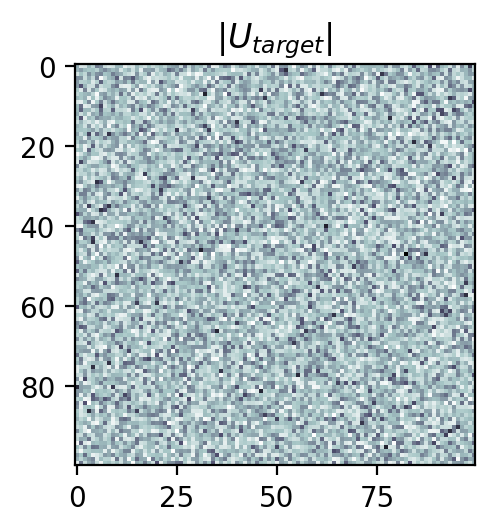

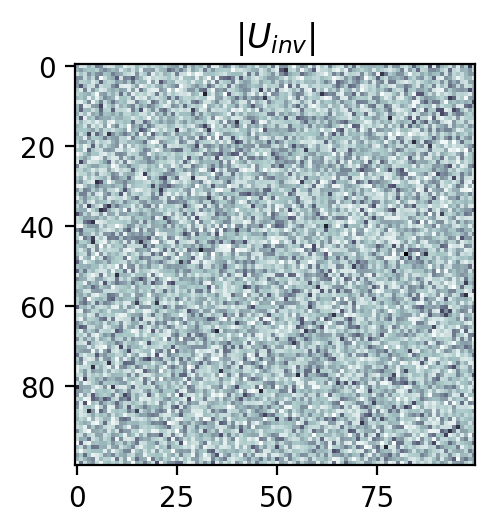

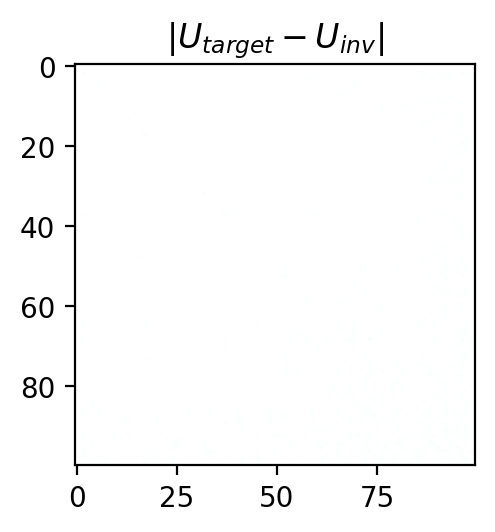

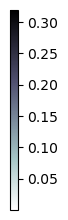

In [21]:
# Plot target, achieved, and error unitary matrices
plot_unitary(U_target.cpu(), VMAX, r"$|U_{target}|$", colorbar_flag=False)
plot_unitary(U_num_inv.cpu(), VMAX, r"$|U_{inv}|$", colorbar_flag=False)
plot_unitary(torch.abs(U_num_inv - U_target).cpu(), VMAX, r"$|U_{target}-U_{inv}|$", colorbar_flag=True)

#### Plot wave propagation

In [22]:
# Clear GPU cache before visualization
torch.cuda.empty_cache()

# Reduce monitoring frequency to speed up plotting
tdwg_pnn.solver.Ncom = 2  # Store only every other propagation step to save some memory and plotting time

# Simulate propagation of first 3 modes for visualization
# Using torch.eye is a convenient way to create a batch that excites each input mode
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(NMODES, dtype=torch.complex64)[[0, 1, 2]], monitor=True)

In [23]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot intensity: convert z to mm, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

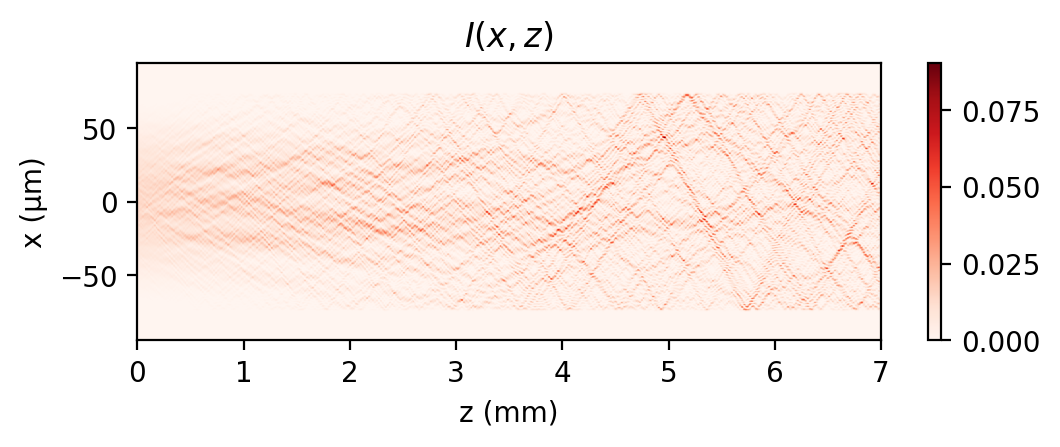

In [24]:
IND = 0  # Index of mode to visualize

# Extract electric field for mode from solver
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()

# Compute intensity: |E|²
Imat_x = Emat_x.abs().square()

# Downsample z-axis based on monitor interval (Ncom)
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]

# Plot intensity evolution through waveguide
plot_intensity(z_list, X_AXIS, Imat_x.T)

In [25]:
# # Load saved model checkpoint
# checkpoint = torch.load('saved_model.pt', weights_only=True)
# tdwg_pnn.load_state_dict(checkpoint['model_state_dict'])
# print(f'Saved at epoch {checkpoint["epoch"]} with loss {checkpoint["loss"]}')
# tdwg_pnn.eval()
# tdwg_pnn.train()  # Uncomment to continue training